# Create agents and pairs
Create noised version of the reference matrix and pair up individual agents.

In [55]:
import glob
from animal_game.utils import compute_thresholds
from animal_game.agents import Agent
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from multiprocessing import Pool
from pathlib import Path

Set hyperparameters and useful variables

In [56]:
space = 'wiki'
model_path = 'animal_game/models'
bins = 20
agents_per_bin = 100
date = '21_08_20'

Get animal names, and distance thresholds

In [57]:
models = [f'{model_path}/{space}_euclidean_distance.tsv']
animals = pd.read_csv(f'{model_path}/animal_list.csv')
animals_idx_dict = dict(zip(animals['Animals'].tolist(),
                        list(range(len(animals)))))
thresholds = compute_thresholds(models, 
                                q=[round(n,2) for n in np.arange(0.05, 1.0, 0.05)], 
                                round_at=5)

Import the vector space and scale it.

In [58]:
vecs = pd.read_csv(f'{model_path}/{space}_vectors.tsv', 
                   sep='\t', index_col=0, header=None)
vecs_scaled = MinMaxScaler().fit_transform(vecs)

Import distance matrix, convert distances to long format, cut into quantiles.

In [59]:
dists = pd.read_csv(models[0], sep='\t', index_col=0)
dists.values[np.tril_indices(dists.values.shape[0], 0)] = np.nan
long_dists = pd.melt(dists.reset_index(), id_vars='index').dropna()
long_dists.columns = ['animal_1', 'animal_2', 'distance']
long_dists['distance_bins'] = pd.cut(long_dists.distance, 
                                      bins,
                                      labels=range(bins)).astype(float)

Now let's create a number of agents for each "noise level": for each quantile, we swap the position in the vector space of each pair of animals whose distance is below that quantile. <br> To introduce diversity between agents, we change the order in which the swapping is performed.

In [60]:
for p in ['noised_vectors', 'noised_distance_matrices']:
    opath = Path(model_path)/date/p
    opath.mkdir(parents=True, exist_ok=True)

In [61]:
noised_dists = []
noised_vecs = []

for b in range(bins):
    print(f'Processing bin {b+1} of {bins}')
    bin_df = long_dists[long_dists['distance_bins'] <= b]

    for a_idx in range(agents_per_bin):
        subthr_pairs = list(bin_df.sample(frac=1.)[['animal_1', 
                                                    'animal_2']].to_records(index=False))
        
        # Get new index order
        idx_dict_copy = animals_idx_dict.copy()
        for animal_1, animal_2 in subthr_pairs:
            idx_1 = idx_dict_copy[animal_1]
            idx_2 = idx_dict_copy[animal_2]
            idx_dict_copy[animal_1] = idx_2
            idx_dict_copy[animal_2] = idx_1
        new_idx = dict(sorted(idx_dict_copy.items(), 
                              key=lambda item: item[1])).keys()

        # Make and save vecs
        fname = f'{space}_{b}_{a_idx}.tsv'
        agent_vec_df = pd.DataFrame(vecs_scaled.copy())
        agent_vec_df.index = new_idx
        agent_vec_df = agent_vec_df.reindex(animals_idx_dict.keys())
        agent_vec_df.to_csv(f'{model_path}/{date}/noised_vectors/{fname}',
                            sep='\t')
        noised_vecs.append((a_idx, b, agent_vec_df))

        # Make and save distances
        agent_dist = euclidean_distances(agent_vec_df.values, 
                                         agent_vec_df.values) / 400
        agent_dist_df = pd.DataFrame(agent_dist)
        agent_dist_df.index = agent_vec_df.index
        agent_dist_df.columns = agent_dist_df.index
        agent_dist_df.to_csv(f'{model_path}/{date}/noised_distance_matrices/{fname}',
                             sep='\t')
        noised_dists.append((a_idx, b, agent_dist_df))

Processing bin 1 of 20
Processing bin 2 of 20
Processing bin 3 of 20
Processing bin 4 of 20
Processing bin 5 of 20
Processing bin 6 of 20
Processing bin 7 of 20
Processing bin 8 of 20
Processing bin 9 of 20
Processing bin 10 of 20
Processing bin 11 of 20
Processing bin 12 of 20
Processing bin 13 of 20
Processing bin 14 of 20
Processing bin 15 of 20
Processing bin 16 of 20
Processing bin 17 of 20
Processing bin 18 of 20
Processing bin 19 of 20
Processing bin 20 of 20


## Create pairs

Define function to compute distances

In [62]:
def _compute_distance(pair):
    ''' Computes distance between pair of agents '''
    distance = np.mean(np.sqrt(np.sum(np.square(pair[0][2] - pair[1][2]), axis=1)))
    noise_level1 = pair[0][1]
    noise_level2 = pair[1][1]
    idx1 = pair[0][0]
    idx2 = pair[1][0]
    return (idx1, idx2,
            noise_level1, noise_level2,
            distance)

Compute distances between all pairs of agents

In [63]:
pair_dists = {}
for b in range(bins):
    b_vecs = [nv for nv in noised_vecs if nv[1] == b]
    b_combs = list(itertools.combinations(b_vecs, 2))
    pool = Pool(processes=20)
    b_dists = pool.map(_compute_distance, b_combs)
    pair_dists[b] = b_dists
    pool.close()

Visualize the distribution of distances by noise level

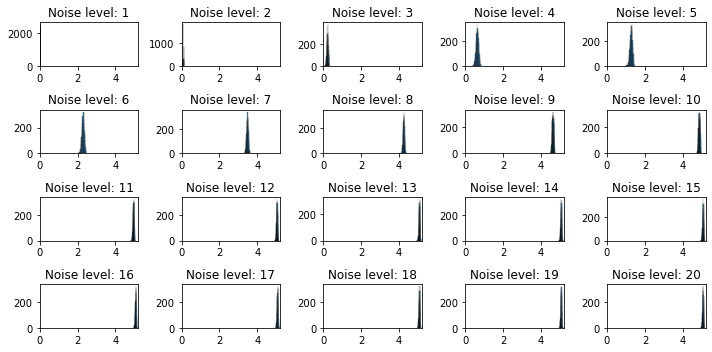

In [66]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10,5))
ax_idx = list(itertools.product(range(4), range(5)))
for k in pair_dists.keys():
    sns.histplot(x=[r[-1] for r in pair_dists[k]], 
                 ax=ax[ax_idx[k]])
    ax[ax_idx[k]].set_xlim(0,5.2)
    ax[ax_idx[k]].set_ylabel('')
    ax[ax_idx[k]].set_title(f'Noise level: {k+1}')
plt.tight_layout()
plt.show()

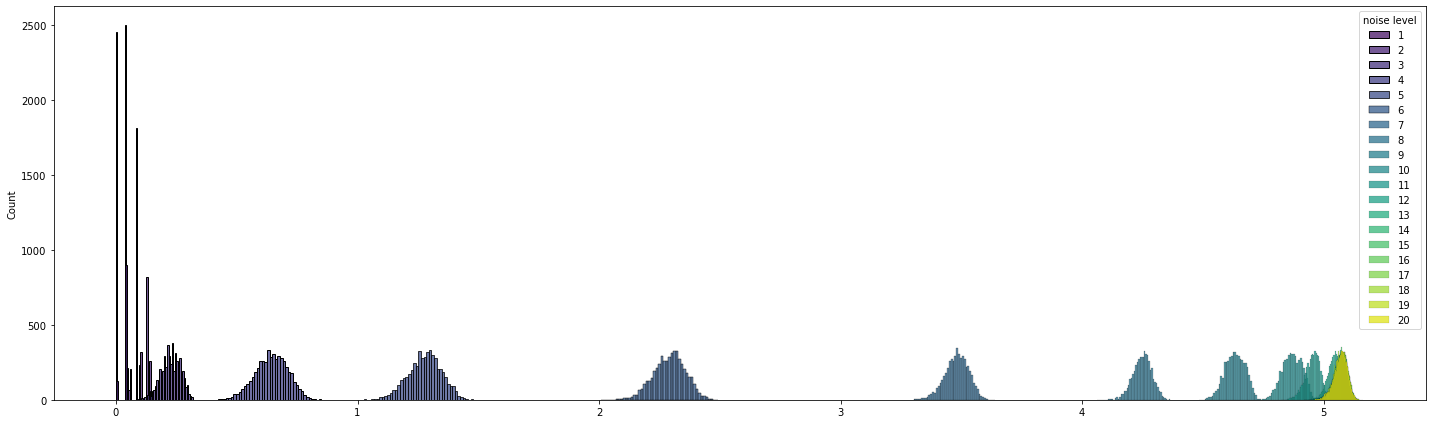

In [89]:
colors = sns.color_palette('viridis', 20)
fig, ax = plt.subplots(figsize=(20,6))
for idx, k in enumerate(pair_dists.keys()):
    sns.histplot(x=[r[-1] for r in pair_dists[k]], color=colors[idx], label=k+1)
plt.legend(title='noise level')
plt.tight_layout()
plt.show()

Okay, we should keep in mind that from noise level 12 onwards **there seems to be little difference in terms of the distribution of distances**. <br>
Now let's sample pairs per noise level.

In [67]:
for idx, k in enumerate(pair_dists.keys()):
    pair_dist_df = pd.DataFrame(pair_dists[k], columns=['idx1', 'idx2', 
                                                        'noise_level1', 'noise_level2',
                                                        'distance'])
    for c in ['idx1', 'idx2', 'noise_level1', 'noise_level2']:
        pair_dist_df[c] = pair_dist_df[c].astype(str)
    if idx == 0:
        pairs_dist_df = pair_dist_df
    else:
        pairs_dist_df = pd.concat([pair_dist_df, 
                                   pairs_dist_df], ignore_index=True)

In [68]:
pairs_dist_df['fname_1'] = 'wiki_' + pairs_dist_df['noise_level1'] + '_' + pairs_dist_df['idx1'] + '.tsv'
pairs_dist_df['fname_2'] = 'wiki_' + pairs_dist_df['noise_level2'] + '_' + pairs_dist_df['idx2'] + '.tsv'

### Sample pairs

In [69]:
for idx, b in enumerate(range(bins)):
    b_sampled = pairs_dist_df[pairs_dist_df['noise_level1'] == str(b)].sample(n=agents_per_bin)
    if idx == 0:
        sampled_all = b_sampled
    else:
        sampled_all = pd.concat([sampled_all, 
                                 b_sampled], ignore_index=False)

In [70]:
sampled_all.to_csv(f'{model_path}/{date}/sampled_pairs.tsv', sep='\t')

### Plot distances of samples per noise level

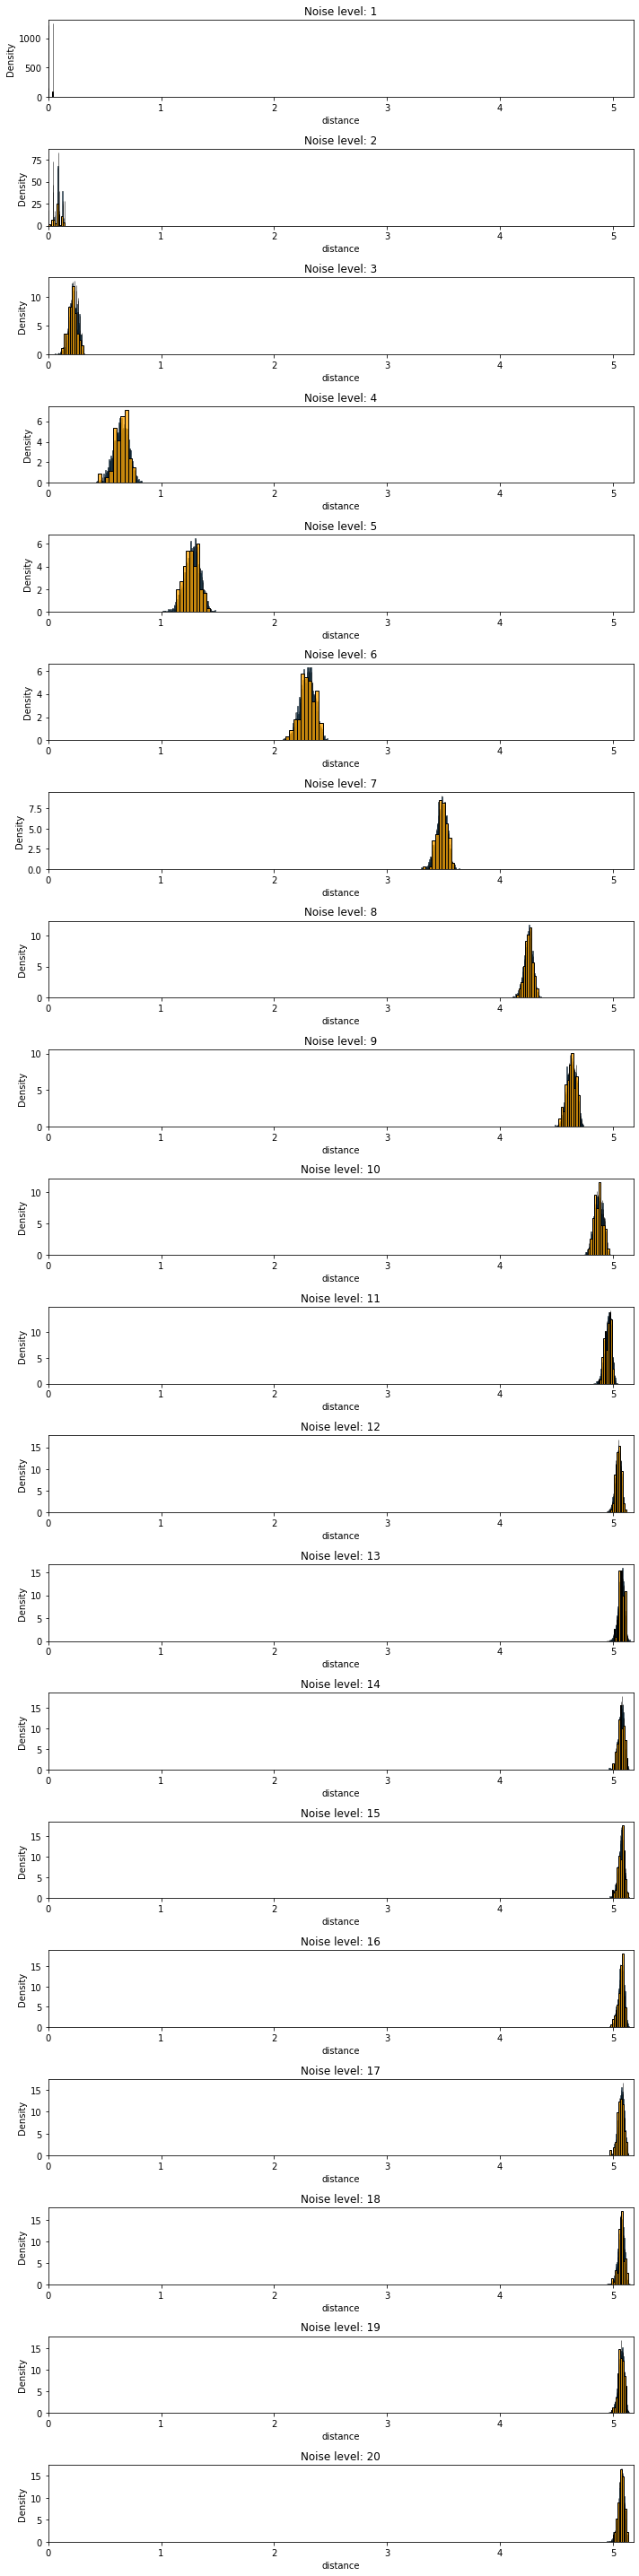

In [76]:
fig, ax = plt.subplots(ncols=1, nrows=20, figsize=(10,40))
for idx, b in enumerate(range(bins)):
    sns.histplot([d[-1] for d in pair_dists[b]], stat='density', 
                 label='all', ax=ax[idx], bins=100)
    sns.histplot(data=sampled_all[sampled_all['noise_level1']==str(b)], 
                 x='distance', stat='density', label='sampled', 
                 color='orange', ax=ax[idx], bins=10)
    ax[idx].set_title(f'Noise level: {idx+1}')
    ax[idx].set_xlim(0, 5.18)
plt.tight_layout()
plt.show()

In [ ]:
### COMING NEXT ###
# Also need to redo the same thing with a couple more thresholds for validity.
# Decide whether we want to do quantiles or equally spaced quantities
# Run whole thing
# Set up pipeline and script for analysis
# Fix the threshold issue
# May want to plot some examples of agents through UMAP (with same transformation, maybe)

In [1]:
## ANALYSIS PLAN
# Show that diversity has an effect of performance of the pair
# Show how this interacts with the performance of the individual
# But show also that higher diversity does not correlate with higher performance difference
# Show whether that correlates with higher mean jump or higher variation in jump length (figure out relative to whom)
# Characterize the dynamics of the interaction by distance level (e.g., through plots, or overall length by performance bins, etc.)